Theano Tutorial @ LTI, Carnegie Mellon Unviersity
=======================

Kazuya Kawakami, Chris Dyer

# Theano

Theano is a Python library, like numpy, that lets you to define mathematical expressions and run them on GPU.

**Pros**

- **Python** : Preprocessing, Modeling, Visualization. Numpy like expression.
- **Easy to access GPU**: You don't need to do anything!!
- **Execution speed optimizations**: Theano can use g++ or nvcc to compile your expression graph
- **Symbolic differentiation**: Automatic Differentiation on symbolic expressions
- **Stability optimizations**: Theano recognize numerically unstable expressions and fix them

**Cons**

- **Loop** : Restrictions on how the loop interact with the rest of the graph
- ** Goto/Recursion**: are not supprted

## Contents
0. **Tools**: You don't need to know theano at all !! ( [nolearn](https://github.com/dnouri/nolearn.git), [Pylearn2](http://deeplearning.net/software/pylearn2/), [sklearn-theano](http://sklearn-theano.github.io/auto_examples/plot_mnist_generator.html#example-plot-mnist-generator-py) ).

1. **Variables**: Symbolic variable, Shared variable
2. **Function, Computational Graph**: tensor.function, tensor.clone, theano.printing.pp, theano.printing.debugprint
3. **Math**:  Comparison, Condition
4. **Linear Algebra**
5. **Gradient**: theano.gradient.grad, theano.gradient.hessian, theano.gradient.jacobian
6. **GPU**: Data type 
7. **Linear Regression**
8. **Multi Layer Perceptron**
9. **Convolution**
10. **Maxpooling**
11. **Scan**
12. **Recurrent Neural Networks**
13. **Exercises**
14. **Links**

## Tools

There are a lots of tools implemented with Theano.
For example, [nolearn](https://github.com/dnouri/nolearn.git) let you write image classification in 30 lines !! 

More examples and tutorials are in [dl_tutorial](https://github.com/oduerr/dl_tutorial/tree/master/lasagne).

You can install all requirements with
```bash
pip install -r https://raw.githubusercontent.com/oduerr/dl_tutorial/master/lasagne/requirements.txt
```

In [28]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy

from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')
mnist_x, mnist_y = mnist.data.astype("float32"), mnist.target.astype("int32") # X is a (n_sample, n_feature=784) matrix
X = mnist_x.reshape(-1, 1, 28, 28) / 255.0 # Reshape sample to 2D image to feed in nolearn.

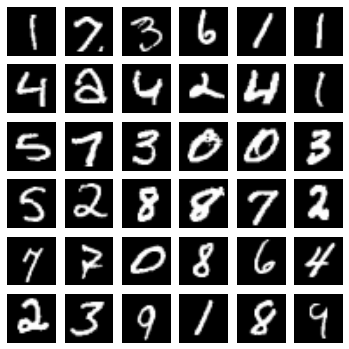

In [29]:
## Show Randomly picked Examples
def plot_sample(x, axis):
    img = x.reshape(28, 28)
    axis.imshow(img, cmap='gray')
    
fig = plt.figure(figsize=(6, 6))
for i in range(36):
    ax = fig.add_subplot(6, 6, i + 1, xticks=[], yticks=[])
    plot_sample(X[numpy.random.randint(0,60000)], ax)

# Neural Network with 648010 learnable parameters

## Layer information

  #  name     size
---  -------  -------
  0  input    1x28x28
  1  hidden1  500
  2  dropout  500
  3  hidden2  500
  4  output   10

  epoch    train loss    valid loss    train/val    valid acc  dur
-------  ------------  ------------  -----------  -----------  -----
      1       1.03898       6.33250      0.16407      0.10426  8.56s
      2       1.13822       6.40487      0.17771      0.10426  8.52s
      3       0.95918       4.14444      0.23144      0.10774  8.58s
      4       0.78294       3.78843      0.20667      0.19801  8.53s
      5       0.80174       3.43885      0.23314      0.24673  8.59s
      6       0.73449       3.21853      0.22821      0.36715  8.55s
      7       0.74906       2.67105      0.28044      0.41094  8.65s
      8       0.65946       2.61052      0.25261      0.37486  8.66s
      9       0.64635       1.80052      0.35898      0.47784  8.57s
     10       0.60580       1.33600

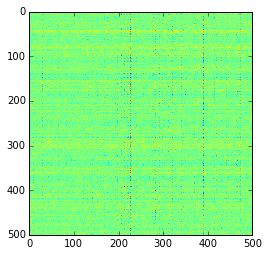

In [14]:
from lasagne import layers
from lasagne import nonlinearities
from nolearn.lasagne import NeuralNet

network = NeuralNet(
    #Define Layers
    layers=[
        ('input', layers.InputLayer),
        #('conv', layers.Conv2DLayer),
        #('pool', layers.MaxPool2DLayer),
        ('hidden1', layers.DenseLayer),
        ('dropout', layers.DropoutLayer),
        ('hidden2', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],
    #Hidden Unit Size, Activation Function
    input_shape=(None, 1, 28, 28),
    #conv_num_filters=5, conv_filter_size=(3, 3), pool_pool_size=(2, 2),
    hidden1_num_units=500, #854 
    hidden1_nonlinearity=nonlinearities.tanh,
    #dropout_p = 0.5,
    hidden2_num_units=500,
    output_num_units=10, 
    output_nonlinearity=nonlinearities.softmax,

    # learning rate parameters
    update_learning_rate=0.01,
    update_momentum=0.9,
    regression=False,
    max_epochs=10,
    verbose=1,

    # Training test-set split
    eval_size = 0.2
)

#Learn Parameters
net = network.fit(X, mnist_y)

#Visualize weights
weights = network.get_all_params()
hidden1_weight = weights[2].get_value()
plt.imshow(hidden1_weight)

Cool!! however your research is not just simple classification/regression. You will need to implement your algorithm by yourself.

For example, following contents are **not** coverd in several libraries.
- **Layers**: Maxout Layer, Recurrent Layer, Embedding Layers
- **Pretraining Strategies**: Pre-train network with different dataset
- **Transfer Learning**: Multiple Objective function
- **Customized Convolution**: k-max pooling
- **Different Cost function**: hinge loss, huber loss, cosine similarity

## Overview of Theano code

1. Define Symbolic/Shared variables (**Variables**)
2. Construct a computational graph (**Math**)
3. Compile the graph (**Function**)
4. Run!!

In [5]:
# Linar Regression
from collections import OrderedDict
import numpy
import theano
import theano.tensor as T

rng = numpy.random.RandomState(1234)

##  Step1. Define Symbolic / Shared Variables
x, t = T.fvector("x"), T.fvector("t") #input

W = theano.shared(rng.uniform(low=-0.08,high=0.08, size=(5, 3)), name="W") #variables that are shared over iteration: weight, bias
b =  theano.shared(numpy.zeros(3), name="bias")


## Step2. Define graph
y = T.dot(x, W) + b

cost = T.sum((y - t)**2) #Cost function

gW, gb = T.grad(cost, [W, b]) # Take gradient

updates =  OrderedDict({W: W-0.01*gW, b: b-0.01*gb}) # Set update expression in OrderedDict


## Step3. Compile graph
f = theano.function(inputs=[x, t], outputs=[cost, gW, gb], updates=updates, allow_input_downcast=True)


## Step4. Run!!
for epoch in range(5):
    cost, gW, gb = f([-2., -1., 1., 2., 3.], [.4, .3, .5])
    print "epoch:: %d, cost:: %.3f"%(epoch, cost)

epoch:: 0, cost:: 0.295
epoch:: 1, cost:: 0.106
epoch:: 2, cost:: 0.038
epoch:: 3, cost:: 0.014
epoch:: 4, cost:: 0.005


## Variables

In addition to numpy.ndarray, you need to know **Symbolic Variable** and **Shared Variable**.

- **Symbolic Variable** is a symbolic representation of quantities you want to use in functions. (Inputs)
- **Shared Variable** is a variable with **storage** that is shared between functions. (Weights)

In [7]:
import numpy
import theano
import theano.tensor as T

In [124]:
## Symbolic Variables 
a = T.iscalar("a")   # integer
b = T.fscalar("b")  # float scalar

x = T.fvector("x")  # float vector
X = T.fmatrix("X") # float matrix

## Shared Variable, store variables on cpu/gpu memory
W = theano.shared(numpy.array([0., 1., 2., 3., 4.]).astype("float32"), name="W")
bias  = theano.shared(numpy.float32(5), name="bias")

# Get Value from shared variable
print W.get_value() 

## Define symbolic graph
c = a + b
y = T.dot(x, W) + bias

## Print symbolic graph
print theano.pp(y)

##  Advanced:: You can replace some parts of compitation graph with different variable
d = theano.clone(output=c, replace={b: y}) #replace "b" with "y"
print theano.pp(d)

[ 0.  1.  2.  3.  4.]
((x \dot W) + bias)
(a + ((x \dot W) + bias))


## Function

Compile symbolic graph into a function

** BE CAREFUL**:: YOU NEED TO USE int32 or float32.

In [125]:
## Compile symbplic graph into callable functions
add = theano.function(inputs=[a, b], outputs=c)
linear = theano.function(inputs=[x], outputs=y)

## Call Functions
print add(1, 5)
print linear([0., 0., 0., 0., 1.]).astype("float32")

##Print function
theano.printing.debugprint(linear)

## Advanced :: You can evaluate symbolic graph without compilation
print c.eval({
                        a : numpy.int32(16), 
                         b : numpy.float32(12.10)
                     })

6.0
9.0
Elemwise{Add}[(0, 0)] [@A] ''   4
 |InplaceDimShuffle{} [@B] ''   3
 | |CGemv{inplace} [@C] ''   2
 |   |Alloc [@D] ''   1
 |   | |TensorConstant{0.0} [@E]
 |   | |TensorConstant{1} [@F]
 |   |TensorConstant{1.0} [@G]
 |   |InplaceDimShuffle{x,0} [@H] ''   0
 |   | |W [@I]
 |   |x [@J]
 |   |TensorConstant{0.0} [@E]
 |bias [@K]
28.1000003815


## Math

Most mathmatic operations are similar to numpy. However, comparison operations have special form. [Basics](http://deeplearning.net/software/theano/library/tensor/basic.html)

 Condition operation is represented by 
 ```python
 T.switch(condition, if true, if false)
 ```
 
 Comparison is represented by
 
 ```python
 T.gt(a, b) #Greater Than
 ```

In [6]:
x = T.fvector("x")

### Basic Math operation
exp_x = T.exp(x)
sigmoid_x = T.nnet.sigmoid(x)
tanh_x = T.tanh(x)

### Advanced:: condition and comparison
relu_x = T.switch(T.gt(x, 0), x, 0)

f = theano.function([x], [exp_x, sigmoid_x, tanh_x, relu_x])
f(numpy.array([-2., -1., 1., 2., 3.]).astype("float32"))

[array([  0.13533528,   0.36787945,   2.71828175,   7.38905621,  20.08553696], dtype=float32),
 array([ 0.11920292,  0.26894143,  0.7310586 ,  0.88079709,  0.95257413], dtype=float32),
 array([-0.96402758, -0.76159418,  0.76159418,  0.96402758,  0.99505478], dtype=float32),
 array([ 0.,  0.,  1.,  2.,  3.], dtype=float32)]

## Gradient (Automatic Differentiation)

You can define gradient symbolically. Amazing!!

If you want to use Jacobian or Hessian, use theano.gradient.jacobian,  theano.gradient.hessian.

In [74]:
# y = x ** 2
x = T.fscalar("x")
y = x ** 2
gy = theano.grad(cost=y, wrt=x) ## 2x

f = theano.function([x], [y, gy]) ## x**2, 2x
print f(10)

[array(100.0, dtype=float32), array(20.0, dtype=float32)]


Update parameters with gradient

**Since we have Autodiff, it's easy to change linear regression to non-linear regression.**

In [75]:
# Linar Regression
from collections import OrderedDict
rng = numpy.random.RandomState(1234)

##  Step1. Define Symbolic / Shared Variables
x, t = T.fvector("x"), T.fvector("t") #input

W = theano.shared(rng.uniform(low=-0.08,high=0.08, size=(5, 3)), name="W") #variables that are shared over iteration: weight, bias
b =  theano.shared(numpy.zeros(3), name="bias")


## Step2. Define graph
y = T.dot(x, W) + b
#y = T.nnet.sigmoid(T.dot(x, W) + b)
#y = T.tanh(T.dot(x, W) + b)
cost = T.sum((y - t)**2)


gW, gb = T.grad(cost, [W, b]) # Take gradient

updates =  OrderedDict({W: W-0.01*gW, b: b-0.01*gb}) # Set update expression in OrderedDict


## Step3. Compile graph
f = theano.function(inputs=[x, t], outputs=[cost, gW, gb], updates=updates, allow_input_downcast=True)

## Step4. Run!!
for epoch in range(5):
    cost, gW, gb = f([-2., -1., 1., 2., 3.], [.4, .3, .5])
    print "epoch:: %d, cost:: %.3f"%(epoch, cost)

epoch:: 0, cost:: 0.295
epoch:: 1, cost:: 0.106
epoch:: 2, cost:: 0.038
epoch:: 3, cost:: 0.014
epoch:: 4, cost:: 0.005


## GPU 

You don't need to know cuda. Just run your code with 
```bash
THEANO_FLAGS=mode=FAST_RUN,device=gpu,floatX=float32, python your_code.py
```

If you want to use [cudnn](https://developer.nvidia.com/cudnn), you need to add one option
```bash
THEANO_FLAGS=mode=FAST_RUN,device=gpu,floatX=float32, optimizer_including=cudnn, python your_code.py
```

If you have access to multiple gpus on your machine, you can specify which device you want to use.
```bash
THEANO_FLAGS=mode=FAST_RUN,device=gpu0,floatX=float32, python your_code.py
THEANO_FLAGS=mode=FAST_RUN,device=gpu1,floatX=float32, python your_code.py
```

Let's check how fast your gpu

```bash
python numpy_knn.py
THEANO_FLAGS=mode=FAST_RUN,device=cpu,floatX=float32, python theano_knn.py
THEANO_FLAGS=mode=FAST_RUN,device=gpu,floatX=float32, python theano_knn.py
```

| MNIST (1-nearest neighbor) | F1@macro           | time |
| ------------- |:-------------:|:-------------:|
| Numpy          | 0.86  |  10.315 |
| Theano (cpu)  | 0.86  |   9.937 |
| Theano (gpu: Titan Black)  | 0.86  |   **4.627** |


In [76]:
#Load Data
from sklearn.utils import shuffle
from sklearn.cross_validation import train_test_split
from sklearn.metrics import f1_score

$$cosine(x, y) = \frac{x}{||x||} \cdot \frac{y}{||y||}$$

In [77]:
#K-Nearest Neighbor - use a label of the closest sample in training data as a prediction
X, y = mnist.data.astype("float32"), mnist.target.astype("int32")
X /= X.sum(axis=1)[:, numpy.newaxis]
train_x, valid_x, train_y, valid_y = train_test_split(X, y, test_size=0.2, random_state=42)

train_x = theano.shared(train_x)
valid_x = theano.shared(valid_x)

closest_sample = T.argmax(T.dot(valid_x, train_x.T), axis=1) #cosine similarity
f = theano.function([], closest_sample)

#Test
closest_sample = f()
pred = train_y[closest_sample]
f1 = f1_score(valid_y, pred, average='macro')
print "F1: %.3f"%(f1)

F1: 0.859


## Multi Layer Perceptron (MLP) 


$$parameters = [ \textbf{W1}, \textbf{b1},  \textbf{W2}, \textbf{b2} ]$$

$$z = \sigma (W1 \cdot x + b1)$$

$$y = softmax(W2 \cdot z + b2)$$

$$L = - log(y[t])$$

$$\theta = \theta - lr * \frac{\partial L}{\partial \theta}$$

In [79]:
#Multi Layer Perceptron
class Layer:
    def __init__(self, in_dim, out_dim, function):
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.function = function

        self.W = theano.shared(rng.uniform(low=-0.08, high=0.08, size=(in_dim, out_dim)).astype("float32"), name="W", )
        self.b =  theano.shared(numpy.zeros(out_dim).astype("float32"), name="bias")
        
        self.params = [ self.W, self.b ]

    def fprop(self, x):
        h = self.function(T.dot(x, self.W)+self.b)
        self.h = h
        return h 

In [85]:
train_x, valid_x, train_y, valid_y = train_test_split(mnist_x, mnist_y, test_size=0.2, random_state=42)

In [ ]:
x, t = T.fmatrix("x"), T.ivector("t")

layers = [
    Layer(784, 500, T.nnet.sigmoid),
    Layer(500, 500, T.nnet.sigmoid),
    Layer(500, 500, T.nnet.sigmoid),
    Layer(500, 10, T.nnet.softmax)
]

## Collect Parameters and Symbolic output
params = []
for i, layer in enumerate(layers):
    params += layer.params
    if i == 0:
        layer_out = layer.fprop(x)
    else:
        layer_out = layer.fprop(layer_out)

## Cost Function (Negative Log Likelihood)
y = layers[-1].h
cost = - T.mean((T.log(y))[T.arange(x.shape[0]), t])

## Gradient
gparams = T.grad(cost, params)
gmomentums = [theano.shared(numpy.zeros_like(param.get_value(borrow=True)).astype("float32")) for param in params]
updates = OrderedDict()

## Defile Learning Rule, you can add Adagrad, Adadelta etc.
lr, momentum = numpy.float32(0.1), numpy.float32(0.9)
for param, gparam, gmomentum in zip(params, gparams, gmomentums,):
    #Clip gradient
    #gparam = theano.gradient.grad_clip(gparam, lower_bound=-5, upper_bound=5)

    # sgd
    #updates[param] = param - lr * gparam

    # momentum
    updates[gmomentum] = momentum * gmomentum - lr * gparam
    updates[param] = param + updates[gmomentum]

              
## Compile 
train = theano.function([x,t],cost,updates=updates)
test = theano.function([x,t],[cost, T.argmax(y, axis=1)])

## Iterate
batch_size = 100
nbatches = train_x.shape[0]//batch_size
for epoch in range(100):
    train_x, train_y = shuffle(train_x, train_y)  # Shuffle Samples !!
    for i in range(nbatches):
            start = i * batch_size
            end = start + batch_size
            train(train_x[start:end], train_y[start:end])
    valid_cost, pred = test(valid_x, valid_y)
    if epoch == 0 or epoch % 10 == 0:
        print "EPOCH:: %i, Validation cost: %.3f, Validation F1: %.3f"%(epoch, valid_cost, f1_score(valid_y, pred))

## Convolution

1D convolution.
$$(f*g)(n) = \sum_{u=-\infty}^{+\infty} f(u) g(n-u) = \sum_{u=-\infty}^{+\infty} f(n-u) g(u)$$

<!--img src="https://upload.wikimedia.org/wikipedia/commons/6/6a/Convolution_of_box_signal_with_itself2.gif"-->

2D convolution.
$$(f*g)(m,n) = \sum_{u=-\infty}^{+\infty} \sum_{v=-\infty}^{+\infty} f(u,v) g(m-u,n-v)$$

Narrow Convolution
<img src="http://ufldl.stanford.edu/wiki/images/6/6c/Convolution_schematic.gif">

Images :: [wiki](https://en.wikipedia.org/wiki/Convolution), [Stanford UFLDL Tutorial](http://ufldl.stanford.edu/wiki/index.php/Feature_extraction_using_convolution)

In [92]:
from theano.tensor.nnet import conv

x = T.fmatrix('x')

##Prepare 3 * 3 line detector and reshape it to (number of filters=1, num input feature maps=1, filter height=3, filter width=3)
W = numpy.array([[1,0,1],[0,1,0],[1,0,1]]).astype("float32").reshape(1, 1, 3, 3)

##Reshape x to 2 * 2 image and convert it to (batch size=1, num input feature maps=1, image height, image width)
## if your image is RGB, num input feature maps=3

#Narrow Convolution
narrow_convoluted_image = conv.conv2d(x.reshape((1, 1, 5, 5)), W, border_mode="valid")
#Wide Convolution
wide_convoluted_image = conv.conv2d(x.reshape((1, 1, 5, 5)), W, border_mode="full")

## Convolution Function
narrow_convolution = theano.function([x], narrow_convoluted_image)
wide_convolution = theano.function([x], wide_convoluted_image)

## Sample Image
sample_image = numpy.array([[1., 1., 1., 0., 0.], [0., 1., 1., 1., 0.], [0., 0., 1., 1., 1.], [0., 0., 1., 1., 0.], [0., 1., 1., 0., 0.]]).astype("float32")

#Original Image
print sample_image

#Convolved Image
narrow_convoluted_image = narrow_convolution(sample_image).reshape(3, 3)
wide_convoluted_image = wide_convolution(sample_image).reshape(7, 7)
print narrow_convoluted_image
print wide_convoluted_image

[[ 1.  1.  1.  0.  0.]
 [ 0.  1.  1.  1.  0.]
 [ 0.  0.  1.  1.  1.]
 [ 0.  0.  1.  1.  0.]
 [ 0.  1.  1.  0.  0.]]
[[ 4.  3.  4.]
 [ 2.  4.  3.]
 [ 2.  3.  4.]]
[[ 1.  1.  2.  1.  1.  0.  0.]
 [ 0.  2.  2.  3.  1.  1.  0.]
 [ 1.  1.  4.  3.  4.  1.  1.]
 [ 0.  1.  2.  4.  3.  3.  0.]
 [ 0.  1.  2.  3.  4.  1.  1.]
 [ 0.  0.  2.  2.  1.  1.  0.]
 [ 0.  1.  1.  1.  1.  0.  0.]]


## Maxpooling

Maxpooling provides robustness to position and reduce dimensions.

In [111]:
from theano.tensor.nnet import conv
from theano.tensor.signal import downsample

x = T.fmatrix('x')

##Prepare 3 * 3 line detector and reshape it to (number of filters=1, num input feature maps=1, filter height=3, filter width=3)
W = numpy.array([[1,0,1],[0,1,0],[1,0,1]]).astype("float32").reshape(1, 1, 3, 3)

##Narrow Convolution
narrow_convoluted_image = conv.conv2d(x.reshape((1, 1, 5, 5)), W, border_mode="valid")

##Pooling  ds take pooling size
pooled_image1 = downsample.max_pool_2d(input=narrow_convoluted_image, ds=(1,3), ignore_border=True)
pooled_image2 = downsample.max_pool_2d(input=narrow_convoluted_image, ds=(1,2), ignore_border=False)
pooled_image3 = downsample.max_pool_2d(input=narrow_convoluted_image, ds=(3,3), ignore_border=False)
mean_pooled_image = T.mean(narrow_convoluted_image, axis=3) #Take mean over row

pooling = theano.function([x], [pooled_image1, pooled_image2, pooled_image3, mean_pooled_image ])

##Print Results
pooled_image = pooling(sample_image)
print pooled_image[0].reshape(3,1)
print pooled_image[1].reshape(3,2)
print pooled_image[2].reshape(1,1)
print pooled_image[3].reshape(3, 1)

[[ 4.]
 [ 4.]
 [ 4.]]
[[ 4.  4.]
 [ 4.  3.]
 [ 3.  4.]]
[[ 4.]]
[[ 3.66666675]
 [ 3.        ]
 [ 3.        ]]


## Scan

Scan is a special function for implementing loop in theano and it's a bit complicated.

In [120]:
##Suppose you have a sequence [1, 2, 3, 4, 5] let's define identity function with scan
x = T.fvector("x")

def step(x):
    return x

h, _ = theano.scan(
                       fn=step,
                       sequences=x, 
                       outputs_info=None
                    )

f = theano.function([x], h)

print f(numpy.array([1, 2, 3, 4, 5]).astype("float32"))

[ 1.  2.  3.  4.  5.]


In [137]:
##Next we define accumulation function
x = T.fvector("x")

def step(x, h_tm1):
    return x + h_tm1

h, _ = theano.scan(
                       fn=step,
                       sequences=x, 
                       outputs_info=0.0, #Initial value for h
                       #go_backwards=True #you might use it for bi-directional RNNs
                    )

f = theano.function([x], h)

print f(numpy.array([1, 2, 3, 4, 5]).astype("float32"))

[  1.   3.   6.  10.  15.]


In [138]:
## Let's do the same thing with matrix, accumulation over column
x = T.fmatrix("x")

def step(x, h_tm1):
    return x + h_tm1

h, _ = theano.scan(
                       fn=step,
                       sequences=x, 
                       outputs_info=numpy.array([0., 0., 0., 0., 0.]) #Initial value for h, it's better to use T.alloc().
                    )

f = theano.function([x], h)

print f(numpy.array([[1, 2, 3, 4, 5], [1, 2, 3, 4, 5], [1, 2, 3, 4, 5]]).astype("float32"))

[[  1.   2.   3.   4.   5.]
 [  2.   4.   6.   8.  10.]
 [  3.   6.   9.  12.  15.]]


In [139]:
## Advanced :: take previous inputs
x = T.fmatrix("x")

def step(x, h_tm1, h_tm2):
    return x + h_tm1 + h_tm2

h, _ = theano.scan(
                       fn=step,
                       sequences=[ dict(input= x, taps = [0, -1, -2])],
                       outputs_info=None #Initial value for h
                    )

f = theano.function([x], h)

print f(numpy.array([[1, 2, 3, 4, 5], [1, 2, 3, 4, 5], [1, 2, 3, 4, 5],[1, 2, 3, 4, 5], [1, 2, 3, 4, 5]]).astype("float32"))

[[  3.   6.   9.  12.  15.]
 [  3.   6.   9.  12.  15.]
 [  3.   6.   9.  12.  15.]]


## Recurrent Networks

Once you could understand scan operation, it's easy to implement RNNs.

In [148]:
x = T.fmatrix("x")

##Define Shared variables
W_in = theano.shared(rng.uniform(low=-0.08, high=0.08, size=(5, 3)).astype("float32"), name="W_in")
W_rec = theano.shared(rng.uniform(low=-0.08, high=0.08, size=(3, 3)).astype("float32"), name="W_rec")
b = theano.shared(numpy.zeros(3).astype("float32"), name="bias")

def step(x, h_tm1, W_in, W_rec, b):
    return T.nnet.sigmoid(T.dot(x, W_in)+ T.dot(h_tm1, W_rec) + b)

h, _ = theano.scan(
                       fn=step,
                       sequences=x,
                       outputs_info=numpy.array([0., 0., 0.]), #Initial value for h
                       non_sequences=[W_in, W_rec, b] #Static variables
                    )

f = theano.function([x], h)

print f(numpy.array([[1, 2, 3, 4, 5], [1, 2, 3, 4, 5], [1, 2, 3, 4, 5],[1, 2, 3, 4, 5], [1, 2, 3, 4, 5]]).astype("float32"))

[[ 0.40920307  0.41049996  0.48682545]
 [ 0.39476634  0.41743034  0.4822858 ]
 [ 0.39484187  0.41757914  0.48255733]
 [ 0.39483721  0.41758297  0.4825557 ]
 [ 0.39483721  0.41758304  0.4825558 ]]


## Exercises

1. Use different cost function, (Cross Entropy)
2. Implement ReLU (Hint. look at Math section)
3. Add Dropout (Hint. apply random mask to inputs in fprop)
4. Add learning rate adjuster (Hint. make learning rate as shared variable)
5. Implement Convolution Layer, Maxpooling Layer
6. Implement RNNs
7. Try different configurations including various convolutions and poolings and see their performances

### Something Wrong??

1. Check data type. You should use "int32", "float32".
2. Check matrix size
3. Check your graph is defined correctly with debug print (DisconnectedInputError, UnusedINputError)
4. Ask developers [Forum](https://groups.google.com/forum/#!forum/theano-users)
5. E-mail me ;)

## Links

## References
1. [Theano Documentation](http://deeplearning.net/software/theano/introduction.html)
2. F. Bastien, P. Lamblin, R. Pascanu, J. Bergstra, I. Goodfellow, A. Bergeron, N. Bouchard, D. Warde-Farley and Y. Bengio. [Theano: new features and speed improvements"](http://arxiv.org/pdf/1211.5590.pdf). NIPS 2012 deep learning workshop.
3. J. Bergstra, O. Breuleux, F. Bastien, P. Lamblin, R. Pascanu, G. Desjardins, J. Turian, D. Warde-Farley and Y. Bengio. [Theano: A CPU and GPU Math Expression Compiler](http://www.iro.umontreal.ca/~lisa/pointeurs/theano_scipy2010.pdf). Proceedings of the Python for Scientific Computing Conference (SciPy) 2010. June 30 - July 3, Austin, TX
4. [Wikipedia, Convolution](https://en.wikipedia.org/wiki/Convolution)
5. [Stanford UFLDL Tutorial](http://ufldl.stanford.edu/wiki/index.php/UFLDL_Tutorial)